In [3]:
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets

In [4]:
# load the data
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)) # (samples, rows, cols, channels)
test_images = test_images.reshape((10000, 28, 28, 1)) # (samples, rows, cols, channels)

# simple normalization of the image pixel values
train_images, test_images = train_images / 255.0, test_images / 255.0
train_image = train_images[0]
train_labels = train_labels[0]
print(train_image.shape)

(28, 28, 1)


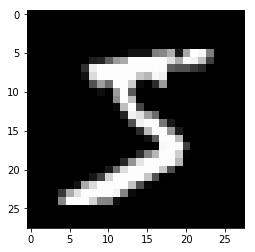

In [5]:
# example of one of the images
plt.figure()
plt.imshow(train_image[:,:,0],cmap='gray')
plt.show()

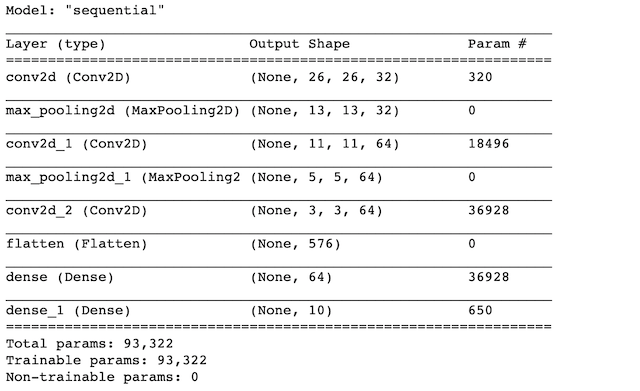

In [6]:
# CNN architecture from TF.Keras example
from IPython.display import Image
Image(filename='/Users/b_eebs/research/ML_notes/Img/architecture.png')

In [7]:
class my_CNN(object):
    
    def __init__(self):
        pass
    
    # dictionaries used later on for the backprop step
    weight_dict = {} 
    bias_dict = {}  
    forward_dict = {}
    unit_dict = {}
    
    # convolution function
    def convolve(self, image, kernel_dim, stride, num_filters, name):
        output = self.get_output(image, kernel_dim, stride, num_filters)
        weights = []
        biases = []
        for k in range(image.shape[-1]): 
            weight,bias = self.get_parameters(image,kernel_dim) # weights change for each depth slice
            weights.append(weight)
            biases.append(bias)
            i_stride = 0
            for i in range(output.shape[1]): 
                j_stride = 0
                for j in range(output.shape[1]):
                    output[i,j,k] = np.sum(image[i_stride:kernel_dim+i_stride,
                                                j_stride:kernel_dim+j_stride,:]*weight) + bias
                    j_stride += stride
                i_stride += stride
        
        # store weights, biases and neuron outputs
        self.weight_dict[name] = weights
        self.bias_dict[name] = bias
        self.forward_dict[name] = output
        
        return output
    
    # function for pooling operation
    def pool(self, conv_output, _image,pool_size, stride, name,fully_connect):
        output = self.get_output(conv_output, pool_size, stride, conv_output.shape[-1])
        pooling_units = []
        i_stride = 0
        for i in range(output.shape[1]):
            j_stride = 0
            for j in range(output.shape[1]):
                                                   
                output[i,j,:] = np.amax(conv_output[i_stride:i_stride+pool_size,
                                                    j_stride:j_stride+pool_size,:])
                pooling_units.append(np.argmax(conv_output[i_stride:i_stride+pool_size,
                                                    j_stride:j_stride+pool_size,:]))
                
                j_stride+=stride
            i_stride+=stride
        self.forward_dict[name] = output
        self.unit_dict[name] = pooling_units

        
        
        # if then statement, if True implement two fully connected layers (last one being prediction) then start backprop
        if fully_connect == False:
            return output
        else:
            # flatten
            p2 = np.reshape(output.flatten(),(1,1600))

            # fully_connected 1
            weight = np.random.randn(64,1600) * 0.01
            bias = np.random.randn(1) * 0.01
            f1 = self.relu(weight.dot(p2.transpose())+bias)
            self.forward_dict['f1'] = f1  
            self.weight_dict['f1'] = weight
            self.bias_dict['f1'] = bias  
            
            # fully_connected 2
            weight = np.random.randn(10,64) * 0.01
            bias = np.random.randn(1) * 0.01
            f2 = self.softmax(weight.dot(f1)+bias)
            self.forward_dict['f2'] = f2
            self.weight_dict['f2'] = weight
            self.bias_dict['f2'] = bias
            
            ######################################
            ############# Backprop ###############
            ######################################
            """
            hn = conv, pn = pool, fn = fully connected
            kn = conv. kernels, bn = conv. bias, wn = fully connected weights, bn_f fully connected bias
            """
            
            h1,p1,h2,_= self.get_forward_dict()
            c1,c2 = self.relu(h1),self.relu(h2)
            f1,f2 = self.forward_dict['f1'],self.forward_dict['f2']
            
            k1,b1,k2,b2,w1,b1_f,w2,b2_f = self.get_parameter_dict()
            # print keys for reference:
            print('forward keys:', self.forward_dict.keys())
            print('weight keys:', self.weight_dict.keys())
            print('bias keys:',self.bias_dict.keys())
            
            _image_arr = np.zeros((10,1))
            _image_arr[_image-1] = 1.
            _image = _image_arr # array of 0s and a single 1 (true value)
            loss = self.loss(f2, _image) # cross entropy
            
            # fc last
            dl2 = f2-_image 
            dw2 = dl2.dot(f1.T)
            db2 = np.sum(dl2,axis = 0)
            
            # fc first 
            dl1 = w2.T.dot(dl2)
            dl1[f1<=0] = 0
            dw1 = dl1.dot(p2)
            db1 = np.sum(dl1,axis = 0)
            
            # pool2
            
            # conv2
            
            # pool1
            
            # conv1
        return output

    # function to get the size of layer output
    def get_output(self, image, kernel_dim, stride, num_filters):
        width = image.shape[0] 
        output_volume = (width-kernel_dim)/stride + 1
        if output_volume.is_integer() == False:
            raise NotImplementedError
        else:
            output_volume = int(output_volume)
            return np.zeros((output_volume,output_volume,num_filters))

    # function to get size of layer parameters
    def get_parameters(self,image, kernel_dim):
        depth = image.shape[-1]
        weight = np.random.randn(kernel_dim, kernel_dim,depth)
        bias = np.random.randn(1)
        return (weight,bias)

    def relu(self,image):
        return np.maximum(0,image)
    
    def softmax(self, image):
        return np.exp(image)/np.sum(np.exp(image))
    
    def loss(self, output, label):
        loss = -np.sum(label * np.log(output))
        return loss
    
    def get_forward_dict(self):
        h1,h2 = self.forward_dict['conv1'],self.forward_dict['conv2']
        p1,p2 = self.forward_dict['pool1'],self.forward_dict['pool2']
        return (h1,p1,h2,p2)
    
    def get_parameter_dict(self):
        k1,k2,w1,w2 = self.weight_dict['conv1'][0],self.weight_dict['conv2'][0],self.weight_dict['f1'],self.weight_dict['f2']
        b1,b2,b1_f,b2_f = self.weight_dict['conv1'],self.weight_dict['conv2'],self.weight_dict['f1'],self.weight_dict['f2']
        return (k1,b1,k2,b2,w1,b1_f,w2,b2_f)

    


In [8]:
conv1 = my_CNN().convolve(train_image,3,1,32,'conv1')
pool1 = my_CNN().pool(conv1,train_labels,2,2,'pool1',False)
conv2 = my_CNN().convolve(pool1,3,1,64,'conv2')
pool2 = my_CNN().pool(conv2,train_labels,3,2,'pool2',True)

#conv3 = my_CNN().convolve(pool2,train_labels,3,1,64,True,'conv3')

forward keys: dict_keys(['conv1', 'pool1', 'conv2', 'pool2', 'f1', 'f2'])
weight keys: dict_keys(['conv1', 'conv2', 'f1', 'f2'])
bias keys: dict_keys(['conv1', 'conv2', 'f1', 'f2'])


In [ ]:
# going through mathematical derivations pooling layer